# Initial Exploratory Data Analysis

## Dependencies

In [1]:
# Datasource link
# https://www.nasa.gov/content/prognostics-center-of-excellence-data-set-repository
# Dataset # 17
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
from os.path import dirname, join

plt.style.use('tableau-colorblind10')
CWD = pathlib.Path().absolute()
DATA_DIR = CWD.parent.parent / 'data' / 'raw'
IMG_DIR = CWD / 'img'

## File size estimation

In [2]:
def get_size_report(data_dir, img_dir):

    files = [i for i in os.listdir(data_dir) if 'h5' in i]
    file_sizes = []
    for file in files:
        file_sizes.append(os.stat(os.path.join(data_dir, file)).st_size / (1024 * 1024))

    sizes = pd.DataFrame({'file': files, 'size (mb)': file_sizes})
    # Convert to pandas series
    sizes = sizes.sort_values(by='file')
    sizes = sizes.set_index('file')['size (mb)']

    plt.figure(figsize=(10, 5))
    plt.bar(sizes.index, sizes.values, zorder=3)
    plt.xticks(rotation=90)
    plt.xlabel("Dataset")
    plt.ylabel("Size (MB)")
    plt.title("Size of each dataset")
    plt.grid(zorder=0)
    # plt.savefig(fname=os.path.join(img_dir, 'size_report.png'),
    #             bbox_inches='tight',
    #             dpi=300)
    plt.show()
    print(f"Training/Validation Data Size: {sizes[sizes.index != 'N-CMAPSS_DS_Validation_f.h5'].sum():.2f} MB")
    print(f"Test Data Size: {sizes[sizes.index == 'N-CMAPSS_DS_Validation_f.h5'].sum():.2f} MB")
    
    return sizes

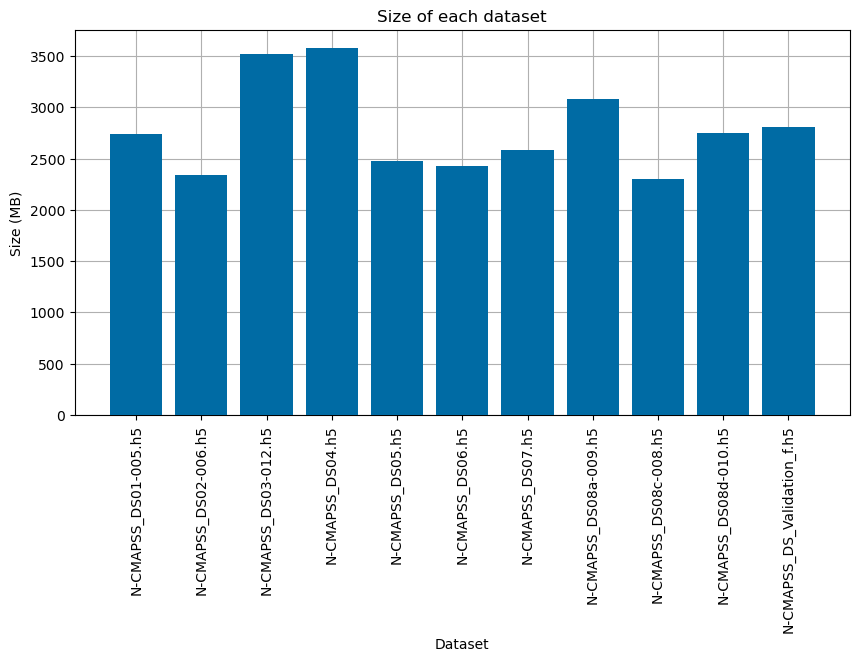

Training/Validation Data Size: 27816.42 MB
Test Data Size: 2807.42 MB


In [5]:
_ = get_size_report(DATA_DIR, IMG_DIR)

Some important comments:

- The dataset seems to be impossible to load in memory for a standard computer
- Given the nature of the problem and the interest of industry, a relatively small Spark Cluster could easily handle the data

## Data Loading

In [3]:
def load_dataset(file_path, measure_interest: str):

    available = ['W', 'X_s', 'X_v', 'T', 'Y', 'A']

    if measure_interest not in available:
        raise ValueError(f"measure_interest must be one of {available}")

    train = f'{measure_interest}_dev'
    test = f'{measure_interest}_test'

    with h5py.File(file_path, 'r') as hdf:

        train_measure = np.array(hdf.get(train))
        test_measure = np.array(hdf.get(test))
    
        if measure_interest == 'Y':
            labels = ['RUL']
        else:
            labels = np.array(hdf.get(f'{measure_interest}_var'))
            labels = list(np.array(labels, dtype='U20'))
            
    data = np.concatenate((train_measure, test_measure), axis=0)
    # Convert to dataframe
    data = pd.DataFrame(data, columns=labels)

    return data

In [4]:
def get_dataset_report(file_path):

    with h5py.File(file_path, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))
        X_s_dev = np.array(hdf.get('X_s_dev'))
        X_v_dev = np.array(hdf.get('X_v_dev'))
        T_dev = np.array(hdf.get('T_dev'))
        Y_dev = np.array(hdf.get('Y_dev'))
        A_dev = np.array(hdf.get('A_dev'))

        # Test set
        W_test = np.array(hdf.get('W_test'))
        X_s_test = np.array(hdf.get('X_s_test'))
        X_v_test = np.array(hdf.get('X_v_test'))
        T_test = np.array(hdf.get('T_test'))
        Y_test = np.array(hdf.get('Y_test'))
        A_test = np.array(hdf.get('A_test'))
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                            
    W = np.concatenate((W_dev, W_test), axis=0)  
    X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
    X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
    T = np.concatenate((T_dev, T_test), axis=0)
    Y = np.concatenate((Y_dev, Y_test), axis=0) 
    A = np.concatenate((A_dev, A_test), axis=0)

    # Set variables to None
    W_dev, X_s_dev, X_v_dev, T_dev, Y_dev, A_dev = None, None, None, None, None, None
    W_test, X_s_test, X_v_test, T_test, Y_test, A_test = None, None, None, None, None, None

    # Delete variables
    del W_dev, X_s_dev, X_v_dev, T_dev, Y_dev, A_dev
    del W_test, X_s_test, X_v_test, T_test, Y_test, A_test

    # Make sizes dictionary
    sizes = {'W_rows': W.shape[0], 'W_cols': W.shape[1],
             'X_s_rows': X_s.shape[0], 'X_s_cols': X_s.shape[1],
             'X_v_rows': X_v.shape[0], 'X_v_cols': X_v.shape[1],
             'T_rows': T.shape[0], 'T_cols': T.shape[1],
             'Y_rows': Y.shape[0], 'Y_cols': Y.shape[1],
             'A_rows': A.shape[0], 'A_cols': A.shape[1]}


    return sizes

In [5]:
def get_size_dataset_report():

    training_files = [i for i in os.listdir(DATA_DIR) if 'h5' in i and 'Validation' not in i]
    shapes = []
    for file in training_files:

        # Corrupted file
        if file == 'N-CMAPSS_DS08d-010.h5':
            continue
        shape = get_dataset_report(os.path.join(DATA_DIR, file))
        shapes.append(shape)

    training_files.remove('N-CMAPSS_DS08d-010.h5')
    df = pd.DataFrame.from_records(shapes, index=training_files)
    df.sort_index(inplace=True)

    plt.figure(figsize=(10, 5))
    plt.bar(df.index, df.W_rows, zorder=3)
    plt.title('Number of rows per dataset')
    plt.xticks(rotation=90)
    plt.xlabel('Dataset')
    plt.ylabel('Number of rows')
    plt.grid(zorder=0)
    plt.savefig(os.path.join(IMG_DIR, 'dataset_shapes.png'),
                bbox_inches='tight', dpi=300)
    plt.show()

    return df


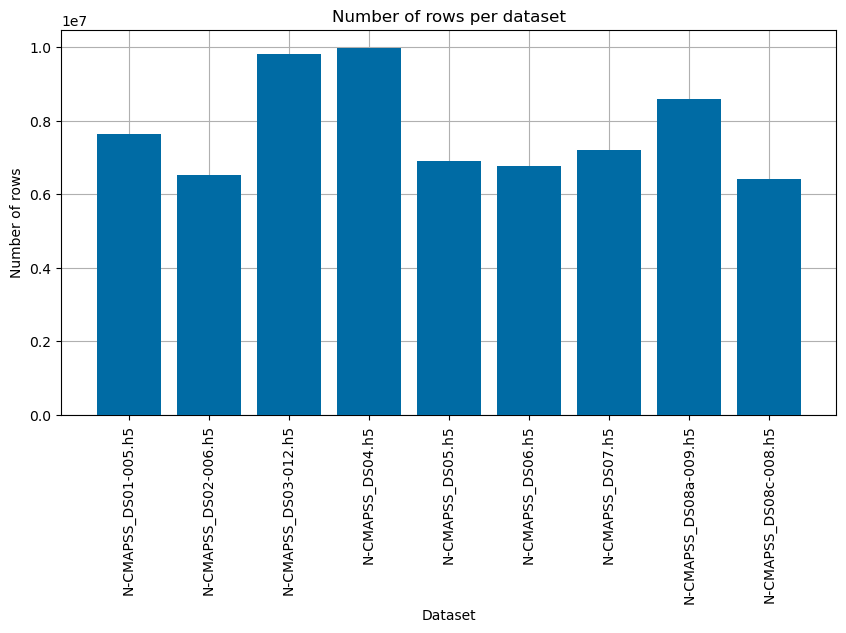

In [10]:
df_sizes = get_size_dataset_report()
df_sizes.to_csv('sizes.csv')


## Data Loaders

In [6]:
dataset = 'N-CMAPSS_DS07.h5'
short_name = dataset.split('_')[1]
df_A = load_dataset(os.path.join(DATA_DIR, dataset), 'A')

## Flights until Failure

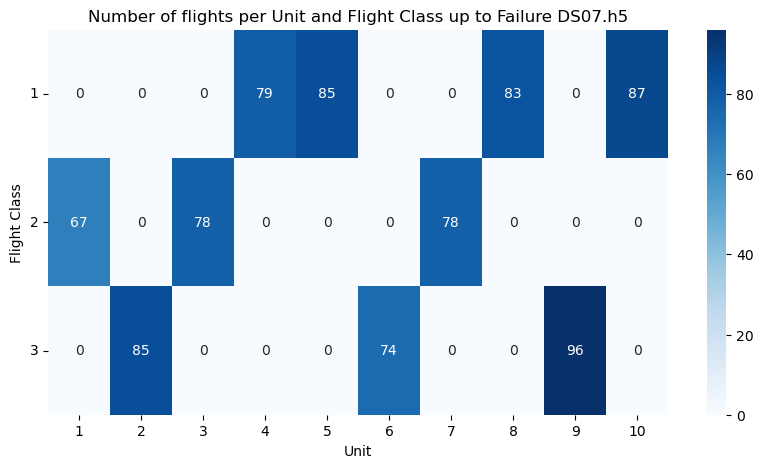

In [13]:
n_flights = df_A.groupby(['unit', 'Fc'])['cycle'].unique().apply(len).unstack()
n_flights = n_flights.fillna(0)
n_flights = n_flights.astype(int)
n_flights.index = n_flights.index.astype(int)
n_flights.columns = n_flights.columns.astype(int)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(n_flights.T, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title(f'Number of flights per Unit and Flight Class up to Failure {short_name}')
ax.set_xlabel('Unit')
ax.set_ylabel('Flight Class')
# Rotate y-labels
plt.setp(ax.get_yticklabels(), rotation=0)
plt.savefig(
    os.path.join(IMG_DIR, f'fligt_class_per_unit_{short_name}.png'), 
    bbox_inches='tight', 
    dpi=300)
plt.show()


## Operating Conditions

In [10]:
def plot_operating_conditions(df_W, unit, cycle):

    data = df_W[(df_W['unit'] == unit) & (df_W['cycle'] == cycle)]
    fig, ax = plt.subplots(figsize=(8, 6), nrows=2, ncols=2, sharex=True)
    t = np.arange(0, len(data), 1)
    ax[0, 0].plot(t, data['alt'])
    ax[0, 1].plot(t, data['Mach'])
    ax[1, 0].plot(t, data['TRA'])
    ax[1, 1].plot(t, data['T2'])
    ax[1, 0].set_xlabel('Time (s)')
    ax[1, 1].set_xlabel('Time (s)')
    ax[0, 0].set_ylabel('Altitude (ft)')
    ax[0, 1].set_ylabel('Mach Number')
    ax[1, 0].set_ylabel('TRA (%)')
    ax[1, 1].set_ylabel('Temperature (°R)')
    # Apply grid to every subplot
    for i in range(2):
        for j in range(2):
            ax[i, j].grid()

    fig.suptitle(f'Operaring Conditions for Unit {unit} - Cycle {cycle}', fontsize=14)
    plt.tight_layout()
    plt.savefig(
        os.path.join(IMG_DIR, f'operating_conditions_unit_{unit}_cycle_{cycle}.png'), dpi=300,
        bbox_inches='tight')
    plt.show()

In [11]:
df_W = load_dataset(os.path.join(DATA_DIR, dataset), 'W')
df_W['unit'] = df_A['unit'].values.astype(int)
df_W['cycle'] = df_A['cycle'].values.astype(int)
df_W['Fc'] = df_A['Fc'].values.astype(int)

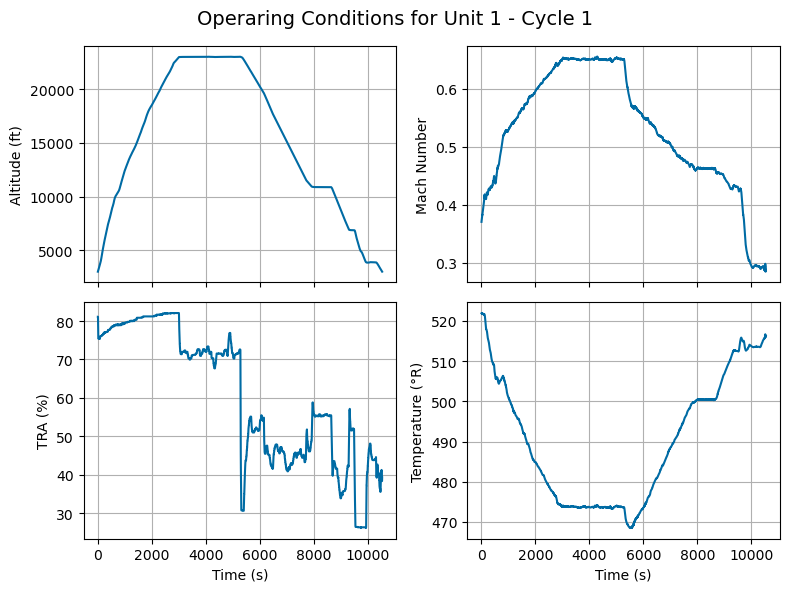

In [12]:
plot_operating_conditions(df_W, 1, 1)

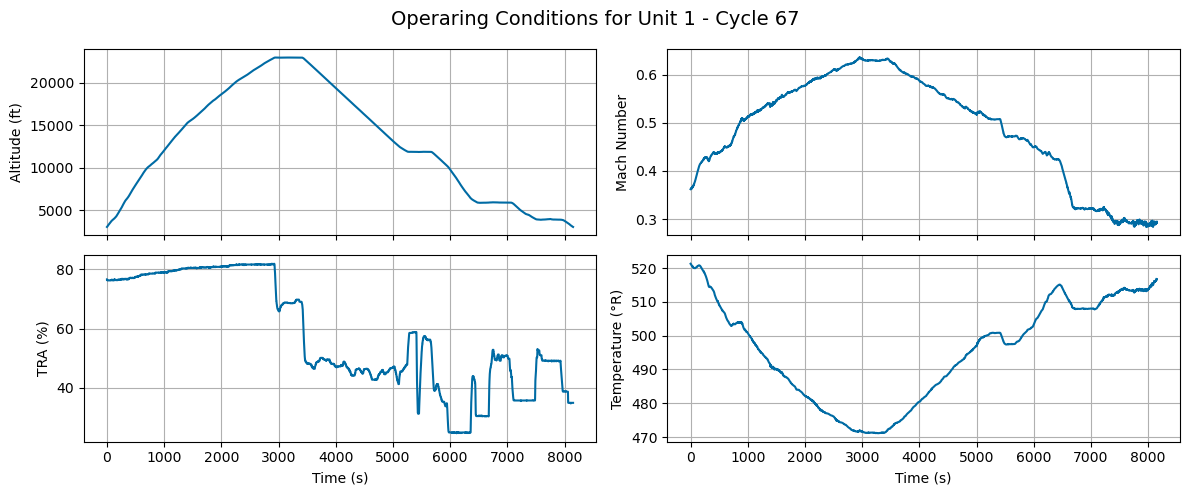

In [17]:
plot_operating_conditions(df_W, 1, 67)

There isn't really a strong difference between the initial flight and the last flight the unit made

## Flight Envelope

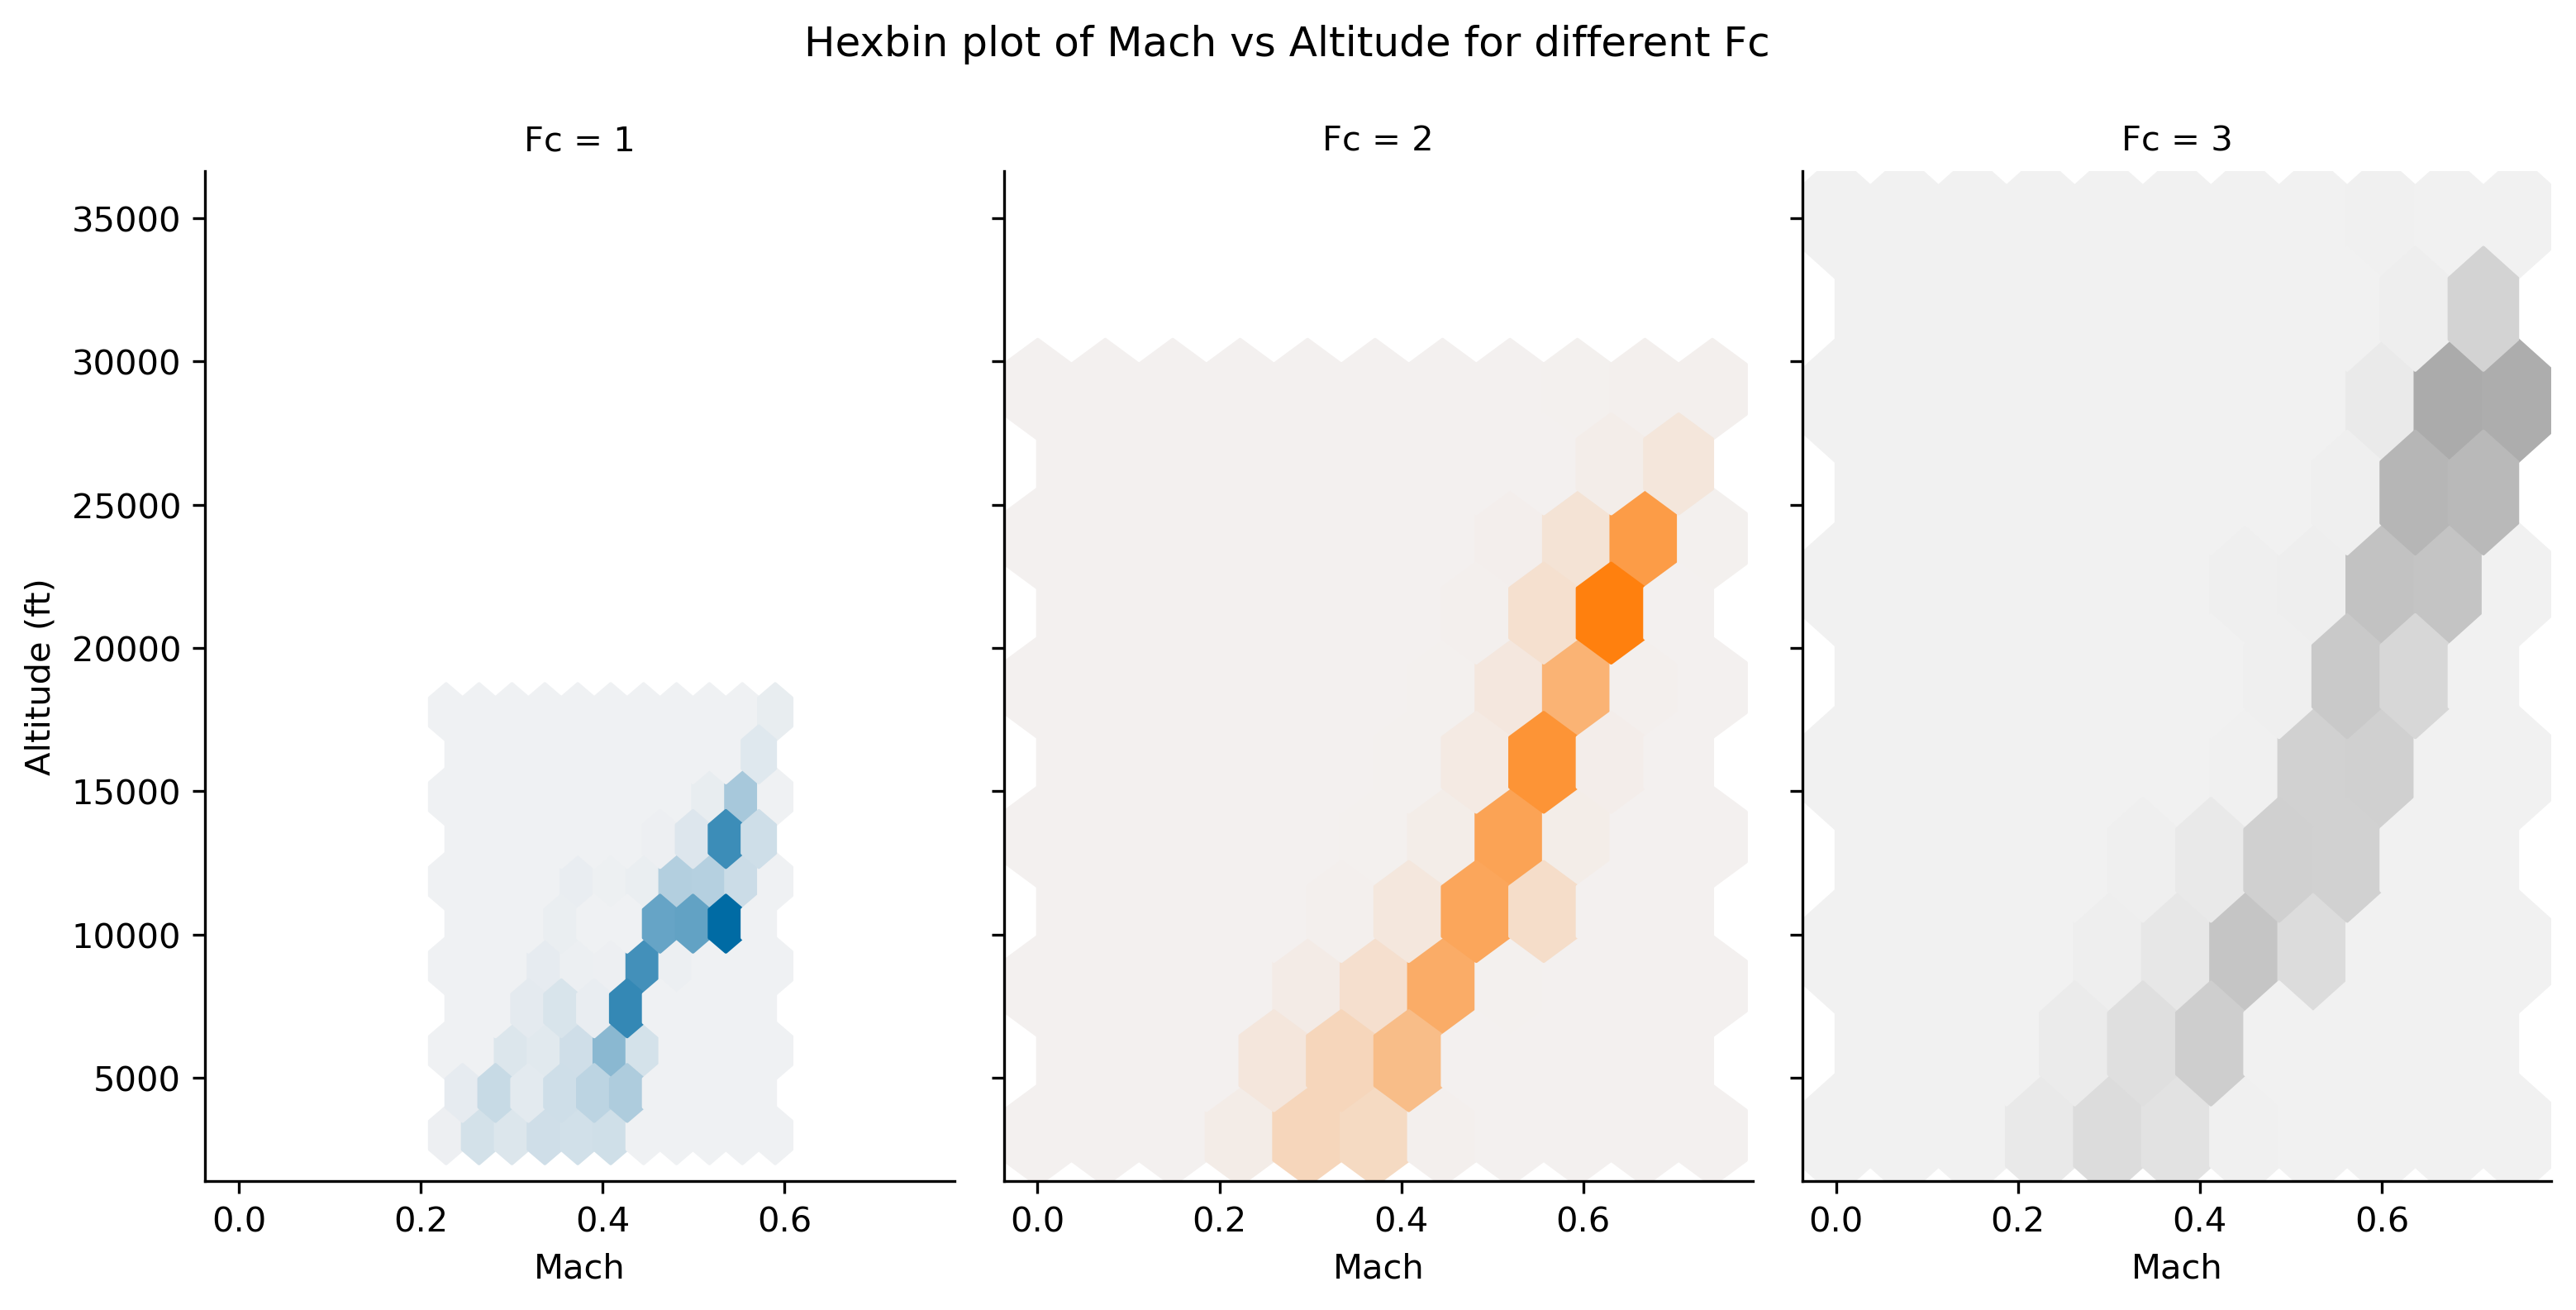

In [26]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=10, cmap=cmap, **kwargs)

# Increase the size of the plot
g = sns.FacetGrid(df_W, hue="Fc", col="Fc", height=5, aspect=0.7)
g.map(hexbin, "Mach", "alt")
g.fig.suptitle("Hexbin plot of Mach vs Altitude for different Fc", y=1.05)
g.fig.set_dpi(300)
g.set_ylabels("Altitude (ft)")
# Save figure
g.savefig(fname=os.path.join(IMG_DIR, 'mach_altitude.png'), bbox_inches="tight", dpi=300)
plt.show()

## Flight Conditions per Flight Class

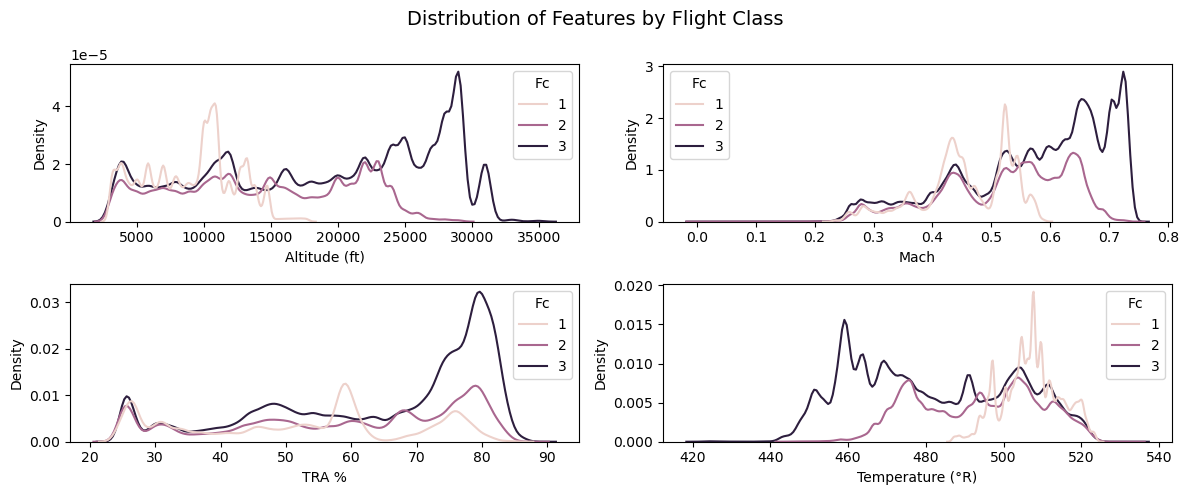

In [19]:
fig, ax = plt.subplots(figsize=(12, 5), nrows=2, ncols=2)
fig.subplots_adjust(right=0.85)
sns.kdeplot(data=df_W, x='alt', hue='Fc', ax=ax[0, 0])
sns.kdeplot(data=df_W, x='Mach', hue='Fc', ax=ax[0, 1])
sns.kdeplot(data=df_W, x='TRA', hue='Fc', ax=ax[1, 0])
sns.kdeplot(data=df_W, x='T2', hue='Fc', ax=ax[1, 1])
ax[0, 0].set_xlabel('Altitude (ft)')
ax[0, 1].set_xlabel('Mach')
ax[1, 0].set_xlabel('TRA %')
ax[1, 1].set_xlabel('Temperature (°R)')
fig.suptitle('Distribution of Features by Flight Class', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(IMG_DIR, 'features_per_condition_fc.png'), dpi=300)
plt.show()

## Sensor Measurements

In [20]:
df_X = load_dataset(os.path.join(DATA_DIR, dataset), 'X_s')
df_Y = load_dataset(os.path.join(DATA_DIR, dataset), 'Y')
df_X['unit'] = df_A['unit'].astype(int)
df_X['cycle'] = df_A['cycle'].astype(int)
df_X['RUL'] = df_Y['RUL'].astype(int)
df_X.columns

Index(['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40',
       'P50', 'Nf', 'Nc', 'Wf', 'unit', 'cycle', 'RUL'],
      dtype='object')

In [21]:
def plot_sensors_unit(unit: int, 
                        sensor: str, 
                        min_cycle: int, 
                        max_cycle: int, 
                        df_X: pd.DataFrame, 
                        save_to_path: str, 
                        show_img: bool =False):

    data = df_X[df_X['unit'] == unit]
    data = data[(data['cycle'] >= min_cycle) & (data['cycle'] < max_cycle)]
    plt.figure(figsize=(10, 5))
    for cycle in data['cycle'].unique():
        cycle_data = data[data['cycle'] == cycle][sensor]
        cycle_data.reset_index(drop=True, inplace=True)
        plt.plot(cycle_data, label=f'Cycle {cycle}')

    plt.xlabel('Time (s)')
    plt.ylabel(sensor)
    plt.grid()
    plt.legend()
    plt.title(f'Unit {unit} - {sensor} Cycles {min_cycle} to {max_cycle-1}')
    plt.tight_layout()
    plt.savefig(
        os.path.join(save_to_path, 
        f'unit_{unit}_{sensor}_cycles_{min_cycle}_{max_cycle-1}.png'), 
        dpi=300)
    
    if show_img:
        plt.show()
    else:
        plt.close()

In [22]:
def plot_all_sensors(unit, n_flights, df_X):
    # Choose only numeric columns
    num_cols = list(df_X.columns)
    num_cols.remove('unit')
    num_cols.remove('RUL')
    num_cols.remove('cycle')

    # Create filters to just plot these trajectories
    max_cycle = df_X[df_X['unit'] == unit].cycle.max()
    mid_cycle = int(0.5 * max_cycle)
    min_cycle = 1
    mid_change = n_flights // 2
    save_to = os.path.join(IMG_DIR, f'sensors_unit_{unit}')

    try:
        os.mkdir(save_to)
    except OSError as error:
        if "File exists" in str(error):
            pass


    for col in num_cols:
        
        # First delta cycles
        plot_sensors_unit(unit=unit, 
                        sensor=col, 
                        min_cycle=min_cycle, 
                        max_cycle=min_cycle+n_flights,
                        df_X=df_X,
                        save_to_path=save_to)
        
        # Middle delta cycles
        plot_sensors_unit(unit=unit,
                        sensor=col,
                        min_cycle=mid_cycle - mid_change,
                        max_cycle=mid_cycle + mid_change+1,
                        df_X=df_X,
                        save_to_path=save_to)
        
        # Last delta cycles
        plot_sensors_unit(unit=unit,
                        sensor=col,
                        min_cycle=max_cycle - n_flights,
                        max_cycle=max_cycle,
                        df_X=df_X,
                        save_to_path=save_to)

In [23]:
plot_all_sensors(2, 3,  df_X)